In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage import data
import os

In [18]:
def imshow(img):
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

Text(0.5, 1.0, 'histogram of grey values')

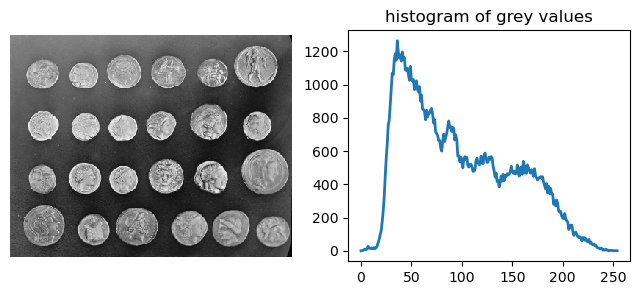

In [19]:
coins = data.coins()
hist = np.histogram(coins, bins=np.arange(0, 256))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 3))
ax1.imshow(coins, cmap=plt.cm.gray, interpolation='nearest')
ax1.axis('off')
ax2.plot(hist[1][:-1], hist[0], lw=2)
ax2.set_title('histogram of grey values')

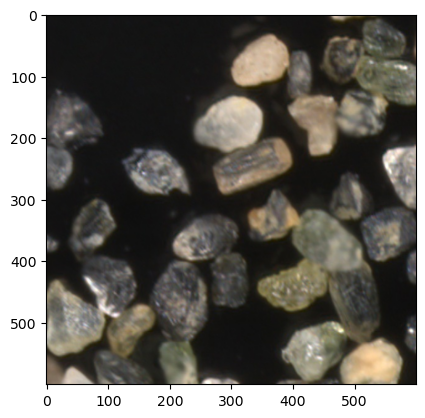

In [20]:
img = cv2.imread('data/Images/Echantillion1Mod2_301.png')
#Convert to rgb
imshow(img)

True

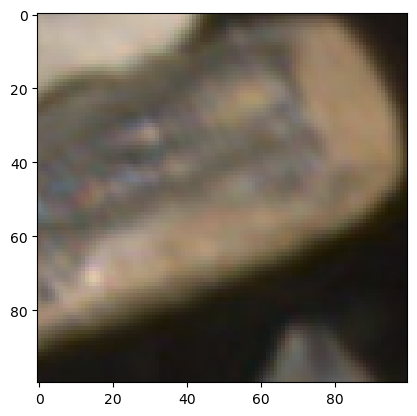

In [21]:
#Crop the image to a new one of 100x100
img_crop = img[200:300, 300:400]
imshow(img_crop)
#save it in data/saved_images
#Get the path of the execution
dir = r'C:\Users\julie\Docu'

cv2.imwrite('data/saved_images/cropped_image2.png', img_crop)

# Performing the algorithm - Region based segmentation

- Elevation map with Sobel
- Get markers (as extreme points of the histogram)
- Apply Watershed with these markers

In [86]:
from skimage.filters import sobel
from skimage.segmentation import watershed
from scipy import ndimage as ndi
import cv2
from superpixel import process_img

In [23]:
def adjust_contrast(image, factor):
    """
    This function adjusts the contrast of an image.
    """
    image_c = np.zeros(image.shape, image.dtype)
    alpha = factor
    beta = 128 * (1 - alpha)
    cv2.addWeighted(image, alpha, np.zeros(image.shape, image.dtype), 0, beta, image_c)
    return image_c

def adjust_brightness(image, factor):
    """
    This function adjusts the brightness of an image.
    """
    image_b = np.zeros(image.shape, image.dtype)
    alpha = factor
    beta = 128 * (1 - alpha)
    cv2.addWeighted(image, alpha, np.zeros(image.shape, image.dtype), 0, beta, image_b)
    return image_b

In [24]:
def mean_shift_filter(image, kernel_size=5, sigma=5):
    """
    This function applies a mean shift filter to an image.
    """
    image_m = np.zeros(image.shape, image.dtype)
    cv2.pyrMeanShiftFiltering(image, kernel_size, sigma, image_m)
    return image_m

def contrast_enhance(img):
    # converting to LAB color space
    lab= cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l_channel, a, b = cv2.split(lab)

    # Applying CLAHE to L-channel
    # feel free to try different values for the limit and grid size:
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    cl = clahe.apply(l_channel)

    # merge the CLAHE enhanced L-channel with the a and b channel
    limg = cv2.merge((cl,a,b))

    # Converting image from LAB Color model to BGR color spcae
    enhanced_img = cv2.cvtColor(limg, cv2.COLOR_LAB2BGR)

    # Stacking the original image with the enhanced image
    return enhanced_img

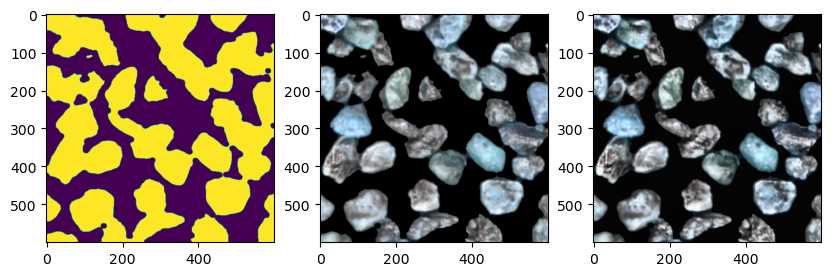

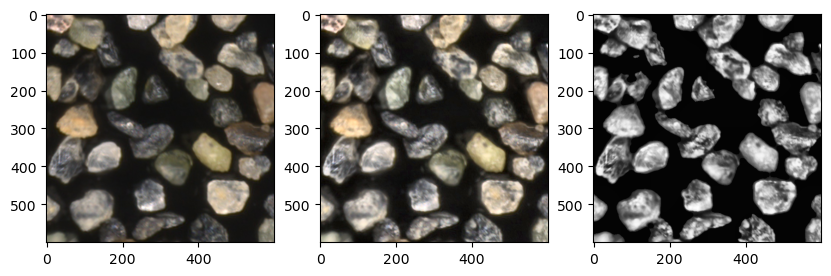

In [90]:
import algo
#Get the image
original = cv2.imread('data/Images/Echantillion1Mod2_304.png')
# img = adjust_contrast(original, 1.5)
# #img = adjust_brightness(img, 1)
# img = mean_shift_filter(img, 10, 5)
p = process_img(original)


#Apply mask to the image
m_img = cv2.bitwise_and(img, img, mask=p[3])

enhanced = contrast_enhance(m_img)

plt.figure(figsize=(10, 10))
plt.subplot(131)
plt.imshow(p[3])
plt.subplot(132)
plt.imshow(m_img)
plt.subplot(133)
plt.imshow(enhanced)
plt.show()

img = contrast_enhance(original)

grey = cv2.cvtColor(enhanced, cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(10, 10))
plt.subplot(131)
imshow(original)
plt.subplot(132)
imshow(img)
plt.subplot(133)
imshow(grey)

Text(0.5, 1.0, 'elevation_map')

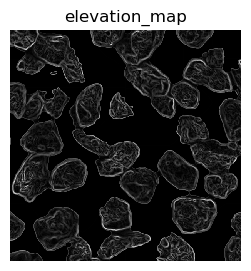

In [91]:
elevation_map = sobel(grey)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(elevation_map, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('elevation_map')

/var/folders/rb/qyycq0gd1vnbf173_z7d_33r0000gn/T/ipykernel_30652/1086179527.py:6: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap("Spectral")


Text(0.5, 1.0, 'markers')

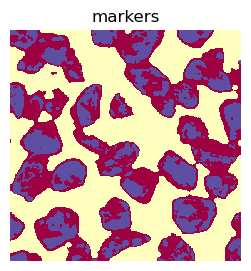

In [92]:
#Get the markers
markers = np.zeros_like(grey)
markers[grey < 10] = 1
markers[grey > 150] = 2

cmap = plt.cm.get_cmap("Spectral")

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(markers, cmap=cmap, interpolation='nearest')
ax.axis('off')
ax.set_title('markers')


Text(0.5, 1.0, 'segmentation')

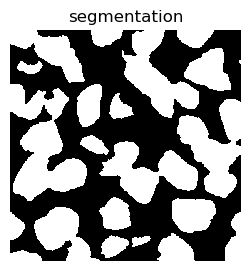

In [99]:
# Apply watershed
segmentation = watershed(elevation_map, markers)

fig, ax = plt.subplots(figsize=(4, 3))
ax.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')
ax.axis('off')
ax.set_title('segmentation')

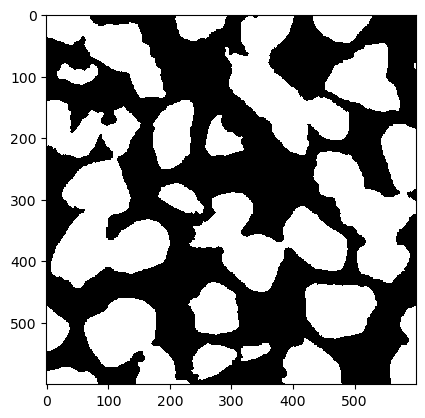

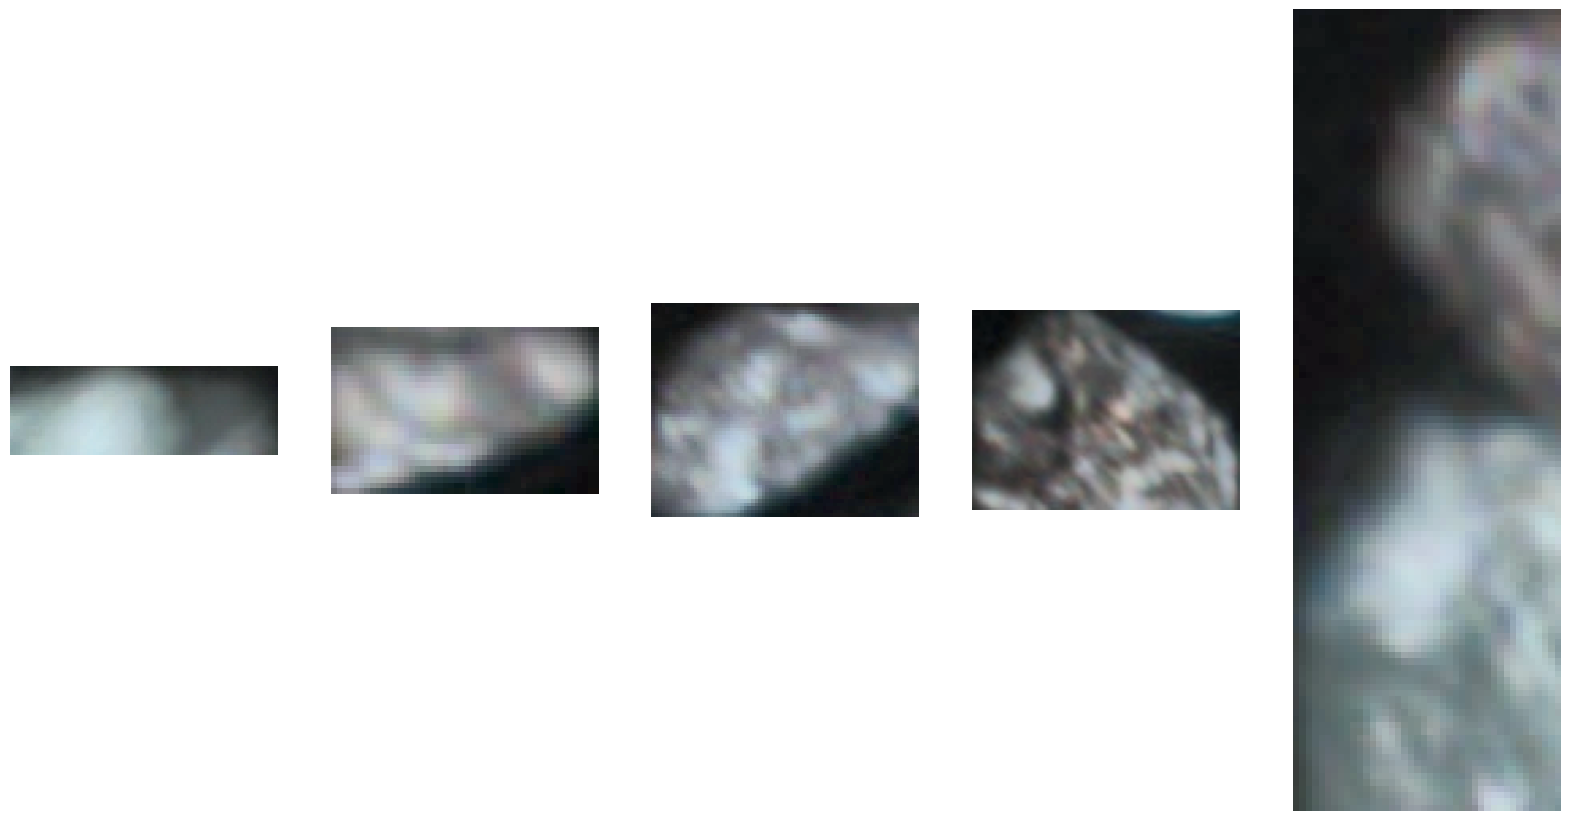

In [100]:
#Get segmentation type
segmentation = ndi.binary_fill_holes(segmentation - 1)
segmentation = segmentation.astype(np.uint8)
plt.imshow(segmentation, cmap=plt.cm.gray, interpolation='nearest')

contours, _ = cv2.findContours(segmentation, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

cropped = []
bounding_boxes = np.zeros((len(contours), 4))
i = 0
for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    bounding_boxes[i] = [x, y, w, h]
    cropped.append(img[y:y + h, x:x + w])
    i += 1

#draw five cropped images
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(cropped[i])
    ax[i].axis('off')

(array([5., 6., 3., 1., 1., 0., 0., 1., 1., 0., 0., 0., 0., 1., 2., 0., 0.,
        0., 0., 1.]),
 array([5.500000e+01, 3.127550e+03, 6.200100e+03, 9.272650e+03,
        1.234520e+04, 1.541775e+04, 1.849030e+04, 2.156285e+04,
        2.463540e+04, 2.770795e+04, 3.078050e+04, 3.385305e+04,
        3.692560e+04, 3.999815e+04, 4.307070e+04, 4.614325e+04,
        4.921580e+04, 5.228835e+04, 5.536090e+04, 5.843345e+04,
        6.150600e+04]),
 <BarContainer object of 20 artists>)

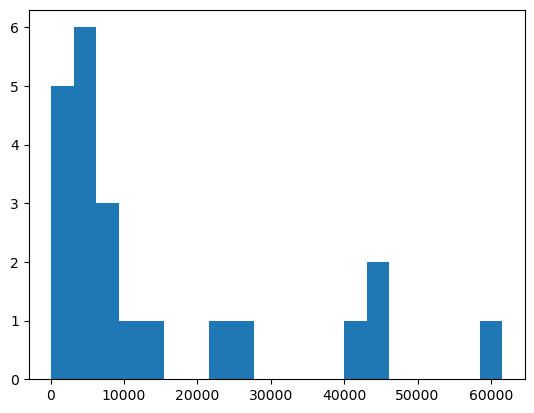

In [101]:
#Draw an histogram of the area of the bounding boxes
areas = bounding_boxes[:, 2] * bounding_boxes[:, 3]
plt.hist(areas, bins=20)

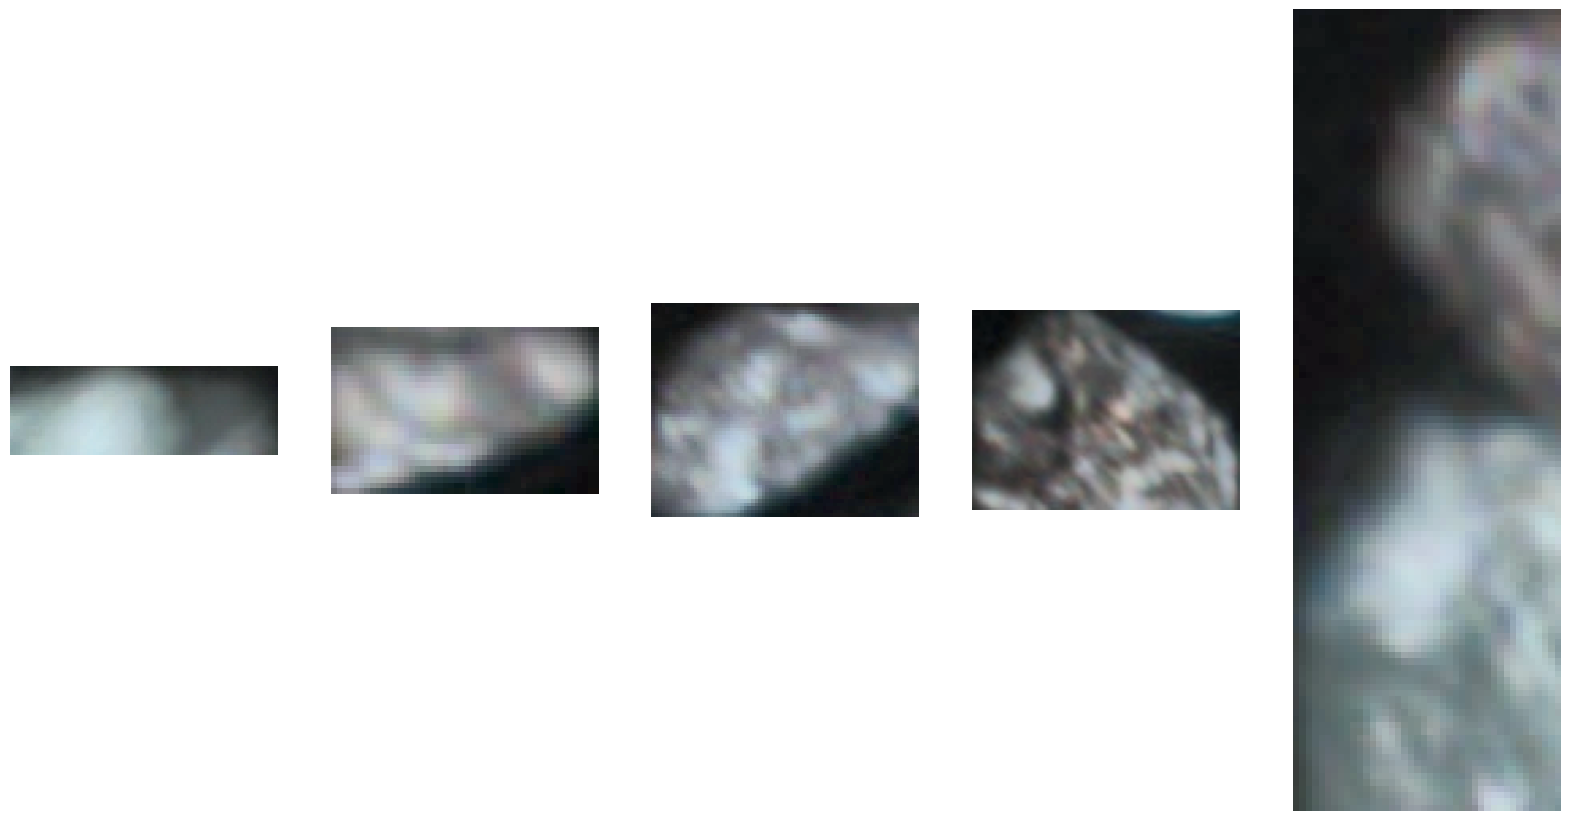

In [102]:
#Clear the least significant bounding boxes : the ones with an area < 2500
bounding_boxes = bounding_boxes[areas > 2500]
cropped = [cropped[i] for i in range(len(cropped)) if areas[i] > 500]

#draw five cropped images
fig, ax = plt.subplots(1, 5, figsize=(20, 20))
for i in range(5):
    ax[i].imshow(cropped[i])
    ax[i].axis('off')

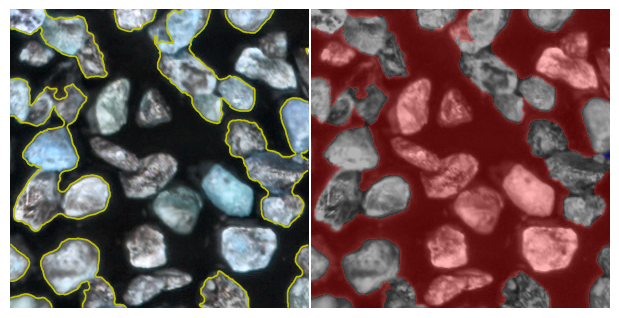

In [103]:
#Get the labels
from skimage.color import label2rgb

segmentation = ndi.binary_fill_holes(segmentation - 1)
labeled_coins, _ = ndi.label(segmentation)
image_label_overlay = label2rgb(labeled_coins, image=img)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(6, 3), sharex=True, sharey=True)
ax1.imshow(img, cmap=plt.cm.gray, interpolation='nearest')
ax1.contour(segmentation, [0.5], linewidths=1.2, colors='y')
ax1.axis('off')
ax1.set_adjustable('box')
ax2.imshow(image_label_overlay, interpolation='nearest')
ax2.axis('off')
ax2.set_adjustable('box')
margins = dict(hspace=0.01, wspace=0.01, top=1, bottom=0, left=0, right=1)
plt.subplots_adjust(**margins)


# TEST

In [123]:
import numpy as np
from scipy.spatial.distance import euclidean
from skimage.color import rgb2gray
from skimage.segmentation import slic
import matplotlib.pyplot as plt
from maxflow import Graph

def graph_segmentation(image, n_segments=1000, compactness=10, beta=50):
    # Convertir l'image en niveaux de gris
    gray = rgb2gray(image)

    # Segmenter l'image en superpixels
    segments = slic(image, n_segments=n_segments, compactness=compactness, sigma=1)

    # Calculer les caractéristiques des superpixels
    means = np.zeros(n_segments)
    stds = np.zeros(n_segments)
    for i in range(n_segments):
        pixels = gray[segments == i]
        means[i] = np.mean(pixels)
        stds[i] = np.std(pixels)

    # Initialiser le graphe
    g = Graph[int](n_segments, n_segments * 4)

    # Ajouter les nœuds au graphe
    nodes = g.add_nodes(n_segments)

    # Ajouter les arêtes au graphe
    for i in range(n_segments):
        for j in range(i+1, n_segments):
            # Calculer la distance entre les superpixels
            dist = euclidean([means[i], stds[i]], [means[j], stds[j]])
            # Calculer le coût d'une arête entre les superpixels
            cost = beta * np.exp(-dist)
            # Ajouter l'arête au graphe
            g.add_edge(i, j, cost, cost)

    # Trouver la partition minimale du graphe
    g.maxflow()

    # Récupérer les régions à partir de la partition
    regions = np.zeros_like(segments)
    for i in range(n_segments):
        regions[segments == i] = g.get_segment(nodes[i])

    # Retourner la carte de régions
    return regions

# Exemple d'utilisation
# Charger une image
image = plt.imread("data/Images/Echantillion1Mod2_304.png")

# Appliquer l'algorithme de segmentation par graphe
regions = graph_segmentation(image, n_segments=250, compactness=10, beta=50)

# Afficher l'image segmentée par le graphe
plt.imshow(regions, cmap='nipy_spectral')
plt.show()


/Users/hdamaia/miniconda3/envs/tp2-vati/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/hdamaia/miniconda3/envs/tp2-vati/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/Users/hdamaia/miniconda3/envs/tp2-vati/lib/python3.10/site-packages/numpy/core/_methods.py:265: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/hdamaia/miniconda3/envs/tp2-vati/lib/python3.10/site-packages/numpy/core/_methods.py:223: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean, casting='unsafe',
/Users/hdamaia/miniconda3/envs/tp2-vati/lib/python3.10/site-packages/numpy/core/_methods.py:257: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)


ValueError: array must not contain infs or NaNs

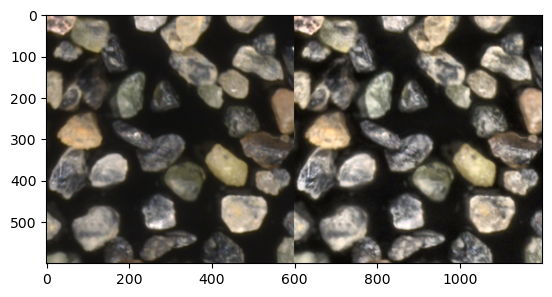

In [6]:
img = cv2.imread('data/Images/Echantillion1Mod2_304.png')

imshow(contrast_enhance(img))